# Gibbs sampling of $f$, $g$, $M=\exp(-C/\epsilon)$

In [201]:
import numpyro
import numpyro.distributions as dist
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config
from tqdm import tqdm
from ott.geometry.geometry import Geometry
from ott.solvers.linear import sinkhorn
import matplotlib.pyplot as plt
config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

In [278]:
# Dimensions of the marginals
m, n = 18, 21

# Remember that we're not observing a probability distribution, but actual counts -- they need to be large.
# Observations of marginal probabilities would require a bit of a different model
num_observations = 1000

# Define "true" marginals
# mu = jnp.ones(m) 
mu_true = jax.random.uniform(key, shape=(m, ))
mu_true = num_observations*mu_true / jnp.sum(mu_true) # uniform marginal

# nu = jnp.array([i**2 for i in range(1, n+1)]) 
nu_true = jax.random.uniform(key, shape=(n, ))
nu_true = num_observations*nu_true / jnp.sum(nu_true)

# Define "true" cost
iota = 1e-6
C_true = jnp.array([[iota + (i - j)**2 for j in range(n)] for i in range(m)], dtype=jnp.float64)

# Normalize cost
C_true = C_true/C_true.sum(axis=0, keepdims=True)

# Generate a transport plan
eps = 5e-2
SH = sinkhorn.solve(Geometry(cost_matrix=C_true, epsilon=eps), a=mu_true, b=nu_true)
T_true = SH.matrix

# Generate A and B. In the balanced case, these are identical to the marginals mu, nu
A, B = T_true.sum(axis=1), T_true.sum(axis=0)

# exp(-C/epsilon)
M_true = jax.lax.exp(-C_true/eps)

# True scaling vectors
f_true = jnp.exp(SH.f/eps)
g_true = jnp.exp(SH.g/eps)

Text(0.5, 1.0, '$T / (f^\\top g) = M$')

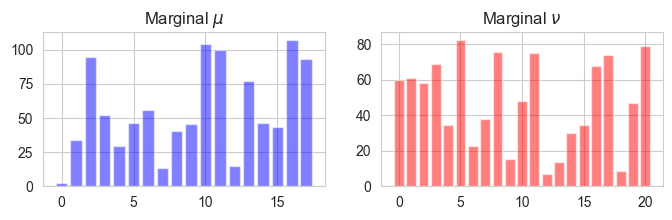

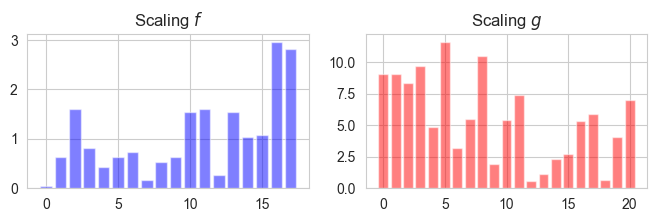

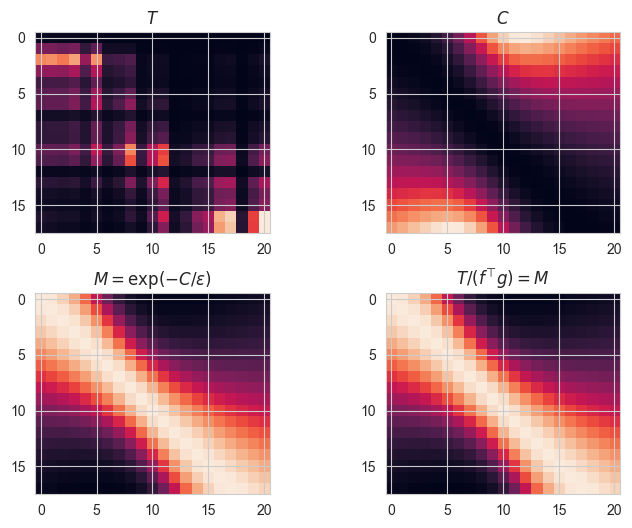

In [279]:
# Plot the marginals
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(mu_true.shape[0]), mu_true, color='blue', alpha=0.5)
axs[0].set_title("Marginal $\mu$")
axs[1].bar(range(nu_true.shape[0]), nu_true, color='red', alpha=0.5)
axs[1].set_title(r"Marginal $\nu$")

# Plot the marginal constraints f, g
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(SH.f.shape[0]), np.exp(SH.f/eps), color='blue', alpha=0.5)
axs[0].set_title("Scaling $f$")
axs[1].bar(range(SH.g.shape[0]), np.exp(SH.g/eps), color='red', alpha=0.5)
axs[1].set_title("Scaling $g$")

# Plot the transport plan, cost matrix, M_matrix, and T / f * g
fig, axs = plt.subplots(2, 2, gridspec_kw=dict(hspace=0.3, wspace=0.3), figsize=(8, 6))
axs = axs.flatten()
axs[0].imshow(T_true)
axs[0].set_title("$T$")
axs[1].imshow(C_true)
axs[1].set_title("$C$")

M_est = T_true / jnp.multiply(f_true.reshape(-1, 1), g_true.reshape(1, -1))
axs[2].imshow(M_true, vmin=np.min([M_est.min(), M_true.min()]), vmax=np.max([M_est.max(), M_true.max()]))
axs[2].set_title("$M = \exp(-C / \epsilon)$")
axs[3].imshow(M_est, vmin=np.min([M_est.min(), M_true.min()]), vmax=np.max([M_est.max(), M_true.max()]))
axs[3].set_title(r"$T / (f^\top g) = M$")

## Triple Sinkhorn

Before implementing a sampler, it should be possible to implement a deterministic version equivalent to a 'triple' Sinkhorn algorithm.

In [276]:
def Sinkhorn(n_iterations, key):
    
    key, _ = random.split(key, 2)

    # Initial values: vector of ones
    f_est = jnp.ones(m)
    g_est = jnp.ones(n)
    
    # Initial value of M: random matrix
    M_est = jax.random.uniform(key, (m, n))
    
    # Iterate the Sinkhorn algorithm until the convergence criterion is reached or the algorithm is terminated.
    for _ in tqdm(range(n_iterations), desc="Sinkhorn"):  
        g_est = nu_true / jnp.matmul(f_est, M_est)
        f_est = mu_true / jnp.matmul(M_est, g_est)
        M_est = T_true / (f_est.reshape(-1, 1) * g_est.reshape(1, -1))
        
        # Constraint to row-normalised cost matrices
        M_est /= (M_est.prod(axis=0, keepdims=True) / np.exp(-1/eps)) ** (1.0/m)
    return f_est, g_est, M_est

Sinkhorn: 100%|██████████| 20000/20000 [00:01<00:00, 11338.87it/s]


Text(0.5, 1.0, 'Estimated $T$')

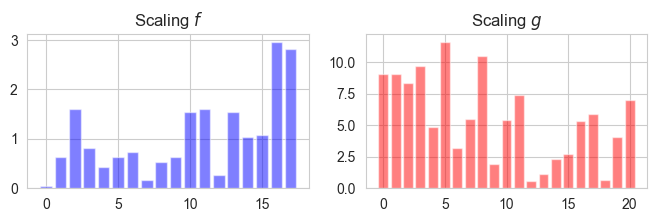

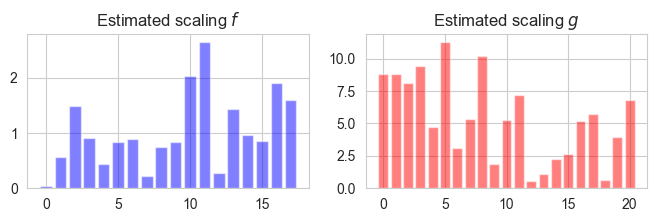

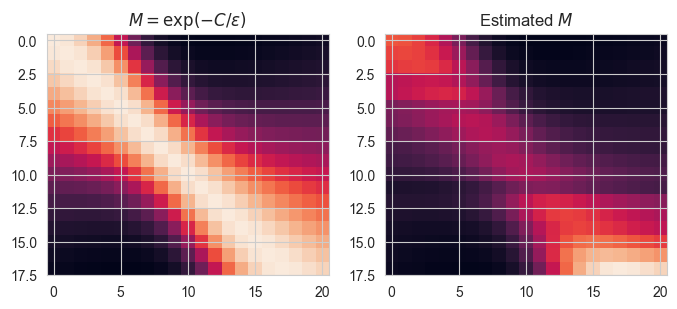

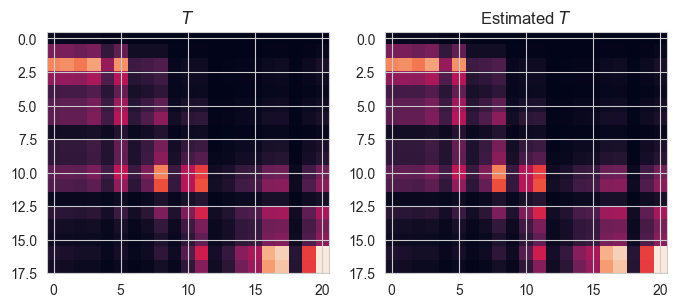

In [277]:
# Run the triple Sinkhorn and plot
f_est, g_est, M_est = Sinkhorn(20000, key)

# Plot the marginal constraints f, g
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(SH.f.shape[0]), np.exp(SH.f/eps), color='blue', alpha=0.5)
axs[0].set_title("Scaling $f$")
axs[1].bar(range(SH.g.shape[0]), np.exp(SH.g/eps), color='red', alpha=0.5)
axs[1].set_title("Scaling $g$")

# Plot the marginal constraints f, g
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(SH.f.shape[0]), f_est, color='blue', alpha=0.5)
axs[0].set_title("Estimated scaling $f$")
axs[1].bar(range(SH.g.shape[0]), g_est, color='red', alpha=0.5)
axs[1].set_title("Estimated scaling $g$")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(M_true)
axs[0].set_title("$M = \exp(-C / \epsilon)$")
axs[1].imshow(M_est / (M_est.prod(axis=0, keepdims=True) / np.exp(-1/eps))**(1.0/m))
axs[1].set_title(r"Estimated $M$")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
T_est = jnp.matmul(jnp.matmul(jnp.diag(f_est), M_est), jnp.diag(g_est))
axs[0].imshow(T_true, vmin=np.min([T_true.min(), T_est.min()]), vmax=np.max([T_true.max(), T_est.max()]))
axs[0].set_title("$T$")
axs[1].imshow(T_est, vmin=np.min([T_true.min(), T_est.min()]), vmax=np.max([T_true.max(), T_est.max()]))
axs[1].set_title(r"Estimated $T$")

## Gibbs sampler
Probabilistic version of the Sinkhorn algorithm as given above

In [305]:
u_0, v_0 = 0, 1e-9
u_1, v_1 = 0, 1e-9

def Gibbs_sampler(*, g_est, M_est, key, **__):
    
    # Split the keys
    key, key_f, key_g, key_M = random.split(key, 4)
    
    # Sample the first scaling vector (f)
    f_est = numpyro.sample("f_est", dist.Gamma(mu_true + u_0, v_0 + jnp.matmul(M_true, g_est)), rng_key=key_f)
    
    # Sample the second scaling (g)
    g_est = numpyro.sample("g_est", dist.Gamma(nu_true + u_1, v_1 + jnp.matmul(f_est, M_true)), rng_key=key_g)
    
    # Sample M
    M_est = numpyro.sample("M_est", dist.Gamma(T_true,  f_est.reshape(-1, 1) * g_est.reshape(1, -1)), rng_key=key_M)
    # M_est /= (M_est.prod(axis=0, keepdims=True) / np.exp(-1/eps)) ** (1.0/m)
    
    # Return a dictionary
    return dict(f_est=f_est, g_est=g_est, M_est=M_est, key=key)

Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 1290.02it/s]


Text(0.5, 1.0, 'Estimated $T$')

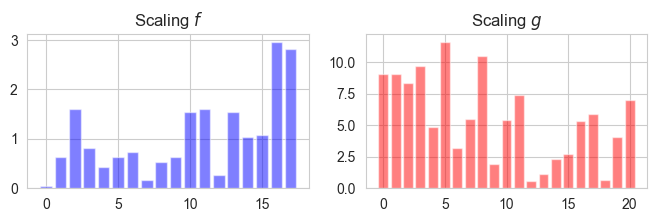

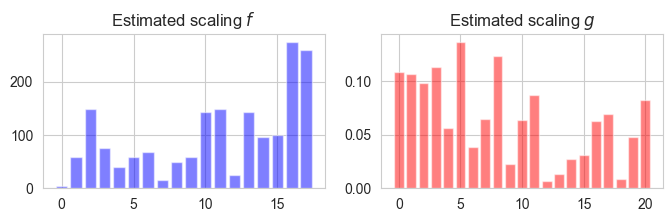

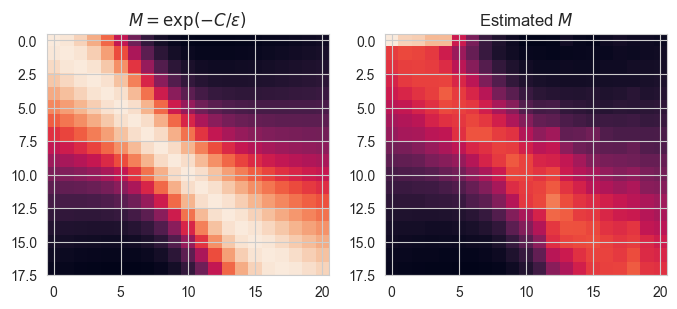

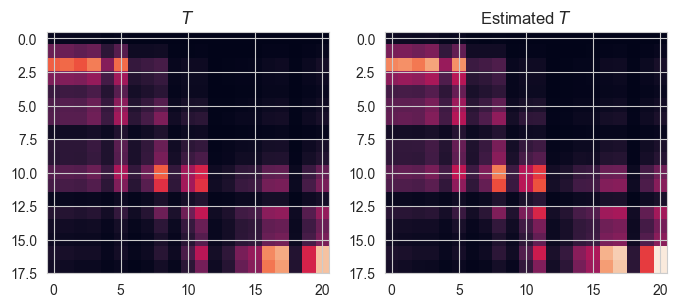

In [306]:
# Initial draw for g and M
key, key_f, key_g, key_M = random.split(key, 4)
init_values = dict(f_est=None, 
                   g_est=jnp.ones(n) / n, 
                   M_est=jax.random.uniform(shape=(m, n), key=key_M), 
                   key=key)

# Collect samples
samples = dict(f_est=[], g_est=[], M_est=[])

# Sample
for _ in tqdm(range(1000), desc="Sampling"):
    init_values = Gibbs_sampler(**init_values) 
    for k, v in init_values.items():
        if k == 'key':
            continue
        samples[k].append(v)

f_est = np.array(samples['f_est']).mean(axis=0)
g_est = np.array(samples['g_est']).mean(axis=0)
M_est = np.array(samples['M_est']).mean(axis=0)

# Plot the marginal constraints f, g
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(SH.f.shape[0]), np.exp(SH.f/eps), color='blue', alpha=0.5)
axs[0].set_title("Scaling $f$")
axs[1].bar(range(SH.g.shape[0]), np.exp(SH.g/eps), color='red', alpha=0.5)
axs[1].set_title("Scaling $g$")

# Plot the marginal constraints f, g
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].bar(range(SH.f.shape[0]), f_est, color='blue', alpha=0.5)
axs[0].set_title("Estimated scaling $f$")
axs[1].bar(range(SH.g.shape[0]), g_est, color='red', alpha=0.5)
axs[1].set_title("Estimated scaling $g$")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(M_true)
axs[0].set_title("$M = \exp(-C / \epsilon)$")
axs[1].imshow(M_est)
axs[1].set_title(r"Estimated $M$")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
T_est = jnp.matmul(jnp.matmul(jnp.diag(f_est), M_est), jnp.diag(g_est))
axs[0].imshow(T_true, vmin=np.min([T_true.min(), T_est.min()]), vmax=np.max([T_true.max(), T_est.max()]))
axs[0].set_title("$T$")
axs[1].imshow(T_est, vmin=np.min([T_true.min(), T_est.min()]), vmax=np.max([T_true.max(), T_est.max()]))
axs[1].set_title(r"Estimated $T$")